# SAT-score analysis in NYC

### In this project, I'll look at the SAT scores of NYC high schoolers, along with various demographic and other information about them. 
The SAT, or Scholastic Aptitude Test, is a standardized test widely used for college admissions in the US. The test is usually taken by high school juniors and seniors. The test is divided into 3 sections, each of which is scored out of 800 points. The total score is out of 2400 (although this has changed back and forth a few times, the scores in this dataset are out of 2400). High schools are often ranked by their average SAT scores, and high SAT scores are considered a sign of how good a school district is.

# Where did the data come from?

The data came from NYC OpenData (https://data.cityofnewyork.us/browse?category=Education)

>I used dataquest blog as a reference - https://www.dataquest.io/blog/data-science-portfolio-project/


In [100]:
import pandas as pd
import numpy as np

files = ['AP_Results.csv',
         'Class_Size.csv',
         'Demographics.csv',
         'Outcomes.csv',
         'Directory.csv',
         'Math_Test_Results.csv',
         'SAT_Results.csv',
         'Outcomes.csv'
        ]

data = {}
for f in files:
    d = pd.read_csv('data/{0}'.format(f))
    data[f.replace(".csv","")] = d

After I've read the data in - I would like to see how each DataFrame looks like:

In [101]:
for k, v in data.items():
    print('\n' + k + '\n')
    print(v.head(5))


Math_Test_Results

      DBN Grade  Year      Category  Number Tested Mean Scale Score Level 1 #  \
0  01M015     3  2006  All Students             39              667         2   
1  01M015     3  2007  All Students             31              672         2   
2  01M015     3  2008  All Students             37              668         0   
3  01M015     3  2009  All Students             33              668         0   
4  01M015     3  2010  All Students             26              677         6   

  Level 1 % Level 2 # Level 2 % Level 3 # Level 3 % Level 4 # Level 4 %  \
0      5.1%        11     28.2%        20     51.3%         6     15.4%   
1      6.5%         3      9.7%        22       71%         4     12.9%   
2        0%         6     16.2%        29     78.4%         2      5.4%   
3        0%         4     12.1%        28     84.8%         1        3%   
4     23.1%        12     46.2%         6     23.1%         2      7.7%   

  Level 3+4 # Level 3+4 %  
0          26 

# Unifying the data

### Since I'm using multiple datasets in my analysis, I would like to unify all individual datasets into a single one.

Looking at the output above, it appears that *DBN* might be the common column, that I need in order to unify as it appears in multiple datasets.

Apparently, *DBN* in NYC Schools is a unique code for each school.



The problem now is that two of the datasets, 
Class_Size, and  Directory, don't have a *DBN* field. 
In the *hs_directory* data, it's just named *dbn*, so we can just rename the column, or copy it over into a new column called *DBN*. In the *class_size* data, we'll need to try a different approach.

The *DBN* column looks like this:

In [102]:
data['Demographics']['DBN'].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

In the Class_Size data it looks like the DBN is actually a combination of *CSD*, *BOROUGH* and *SCHOOL CODE*.

In [103]:
data['Class_Size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


Now I can construct a *DBN* and add it to the Class_Size and Directory datasets:

In [104]:
#Add the 'DBN' column to the 'Class_Size' dataset:
data['Class_Size']['DBN'] = data['Class_Size'].apply(lambda x: 
                    "{0:02d}{1}".format(x["CSD"], x["SCHOOL CODE"]), axis=1)
#Add the 'DBN' column to the 'Directory' dataset:
data['Directory']['DBN'] = data['Directory']['dbn']

Let's just check that the *DBN* column looks fine:

In [105]:
data['Class_Size']['DBN'].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

# Adding in the surveys datasets

I would like to add the data obtained from surveys of parents, teachers, and students at each school. The survey data consists of 2 files:
+ survey_all - for all schools
+ survey_d75 - for school district 75

Here is some code to combine those files into the *data* dictionary:

In [106]:
#Read in the surveys for all schools using 'windows-1252' file encoding:
survey1 = pd.read_csv("data/survey_all.txt", delimiter='\t', 
                      encoding='windows=1252')
#Read in the surveys for discrict 75 schools using 'windows-1252' file encoding:
survey2 = pd.read_csv("data/survey_d75.txt", delimiter='\t', 
                      encoding='windows=1252')
#Add a flag that indicates which school district each dataset is for:
survey1['d75'] = False
survey2['d75'] = True
#Combine the datasets into one:
survey = pd.concat([survey1, survey2], axis=0)

Lets look at the survey DataFrame I created:

In [107]:
survey.head()

,N_p,N_s,N_t,aca_p_11,aca_s_11,aca_t_11,aca_tot_11,bn,com_p_11,com_s_11,...,t_q8c_1,t_q8c_2,t_q8c_3,t_q8c_4,t_q9,t_q9_1,t_q9_2,t_q9_3,t_q9_4,t_q9_5
0,90.0,NaN,22.0,7.8,NaN,7.9,7.9,M015,7.6,NaN,...,29.0,67.0,5.0,0.0,NaN,5.0,14.0,52.0,24.0,5.0
1,161.0,NaN,34.0,7.8,NaN,9.1,8.4,M019,7.6,NaN,...,74.0,21.0,6.0,0.0,NaN,3.0,6.0,3.0,78.0,9.0
2,367.0,NaN,42.0,8.6,NaN,7.5,8.0,M020,8.3,NaN,...,33.0,35.0,20.0,13.0,NaN,3.0,5.0,16.0,70.0,5.0
3,151.0,145.0,29.0,8.5,7.4,7.8,7.9,M034,8.2,5.9,...,21.0,45.0,28.0,7.0,NaN,0.0,18.0,32.0,39.0,11.0
4,90.0,NaN,23.0,7.9,NaN,8.1,8.0,M063,7.9,NaN,...,59.0,36.0,5.0,0.0,NaN,10.0,5.0,10.0,60.0,15.0


ammm... I don't really know what it means.. 
Luckily I downloaded the data dictionary file with the survey data: Survey Data Dictionary.xls. 
This is how the file looks like:

In [108]:
survey_dic = pd.read_excel('data/Survey Data Dictionary.xls')
survey_dic

,2011 NYC School Survey Data Dictionary,Unnamed: 1
0,This data dictionary can be used with the scho...,NaN
1,NaN,NaN
2,Field Name,Field Description
3,dbn,School identification code (district borough n...
4,sch_type,"School type (Elementary, Middle, High, etc)"
5,location,School name
6,enrollment,Enrollment size
7,borough,Borough
8,principal,Principal name
9,studentsurvey,Only students in grades 6-12 partipate in the ...


Now I can remove 'non interesting' columns and keep the more relevant ones.

After checking the dataset - the columns that end whith 10 in the dictionary actually end with 11....

In [109]:
# Unifying the 'DBN' column:
survey['DBN'] = survey['dbn']
# Creating a list of the relevant columns:
survey_fields = ['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', '_N_p', 
                 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11',
                'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11',
                'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 
                 'eng_tot_11', 'aca_tot_11']
# keeping only the relevant columns (survey_fields) in survey:
survey = survey.loc[:,survey_fields]
# adding the survey data to the data dictionary:
data['survey'] = survey
# Making sure the shape of data is right:
survey.shape

(1702, 23)

In [110]:
survey.columns.values

array(['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', '_N_p', 'saf_p_11',
       'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11',
       'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11',
       'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11'], dtype=object)

# Condensing datasets

Now I would like to examine the datasets more closely. The first one is the 'Class_Size' dataset:

In [111]:
data['Class_Size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01M015


There are several rows for each highschool (as shown above by the repeated 'DBN' and 'SCHOOL NAME' fields). That makes sense - since the dataset shows the class size and usually there are more than one class in a school...
However, it is not consistent through the datasets - The 'SAT_Results' dataset has only one row per high school:

In [112]:
data['SAT_Results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


So, In order to combine datasets I'll need to find a way to condense datasets like 'Class_Size' to the point where there is only one single row per high school. Otherwise, there won't be a way to compare SAT scores to class size...
### Condensing the Class_Size dataset:
In order to accomplish that - I will restrict each field to a single value (especially the 'GRADE' and 'PROGRAM TYPE' fields).

In [113]:
# What are the unique values in the 'GRADE ' field?
data['Class_Size']['GRADE '].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

In [114]:
# What are the unique values in the 'PROGRAM TYPE' field?
data['Class_Size']['PROGRAM TYPE'].unique()

array(['GEN ED', 'CTT', 'SPEC ED', nan, 'G&T'], dtype=object)

In [115]:
Class_Size = data['Class_Size']
# Choosing only the relevant value for 'GRADE' (Since SAT are done in high school):
Class_Size = Class_Size[Class_Size['GRADE '] == '09-12']
# Choosing only the relevant value for 'PROGRAM TYPE' = 'GEN ED':
Class_Size = Class_Size[Class_Size['PROGRAM TYPE'] == 'GEN ED']
# If there is still more than one row per school - use the avarage class size:
Class_Size = Class_Size.groupby('DBN').agg(np.mean)
#Reset the index, so DBN is added back in as a column
Class_Size.reset_index(inplace=True)
#Update the dataset in the data dictionary:
data['Class_Size'] = Class_Size


### Condensing the Demographics dataset:
The data was collected for multiple years for the same schools, so there are duplicate rows for each school. I'll only pick rows where the 'schoolyear' field is the most recent available:

In [116]:
data['Demographics']['schoolyear'].unique()

array([20052006, 20062007, 20072008, 20082009, 20092010, 20102011, 20112012], dtype=int64)

In [117]:
Demographics = data['Demographics']
Demographics = Demographics[Demographics['schoolyear'] == 20112012]
data['Demographics'] = Demographics

### Condensing the Math_Test_Results dataset:
This dataset is segmented by 'Grade' and by 'Year'. I can select only a single grade from a single year:

In [118]:
data['Math_Test_Results']['Grade'].unique()

array(['3', '4', '5', '6', 'All Grades', '7', '8'], dtype=object)

In [119]:
data['Math_Test_Results']['Year'].unique()

array([2006, 2007, 2008, 2009, 2010, 2011], dtype=int64)

In [120]:
data['Math_Test_Results'] = data['Math_Test_Results'][data
                                        ['Math_Test_Results']['Year'] == 2011]
data['Math_Test_Results'] = data['Math_Test_Results'][data
                                        ['Math_Test_Results']['Grade'] == '8']    


### Condensing the Outcomes dataset:
This dataset is segmented by 'Cohort' and by 'Demographoc'. I can select only a single Cohort from the 'Total Cohort' Demographic:

In [121]:
data['Outcomes']['Cohort'].unique()

array(['2003', '2004', '2005', '2006', '2006 Aug', '2001', '2002'], dtype=object)

In [122]:
data['Outcomes']['Demographic'].unique()

array(['Total Cohort', 'Male', 'English Language Learners',
       'English Proficient Students', 'Special Education Students',
       'General Education Students', 'Asian', 'Black', 'Hispanic', 'White',
       'Female'], dtype=object)

In [123]:
data['Outcomes'] = data['Outcomes'][data['Outcomes']['Cohort'] == '2006']
data['Outcomes'] = data['Outcomes'][data['Outcomes']['Demographic'] 
                                    == 'Total Cohort']

# Feature Engineerig:

### Total SAT score:
The first thing I can do is compute a 'total SAT score' from the individual columns 'SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', and 'SAT Writing Avg. Score'.

In [124]:
data['SAT_Results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [125]:
data['SAT_Results'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
DBN                                478 non-null object
SCHOOL NAME                        478 non-null object
Num of SAT Test Takers             478 non-null object
SAT Critical Reading Avg. Score    478 non-null object
SAT Math Avg. Score                478 non-null object
SAT Writing Avg. Score             478 non-null object
dtypes: object(6)
memory usage: 22.5+ KB


In [126]:
cols = ['SAT Math Avg. Score', 
        'SAT Critical Reading Avg. Score', 
        'SAT Writing Avg. Score']
# Converting dtype from object to a numeric value:
for c in cols:
    data['SAT_Results'][c] = pd.to_numeric(data['SAT_Results'][c], 
                                           errors='coerce') 
    
# Summing the scores to get the total 'SAT_score':
data['SAT_Results']['SAT_score'] = data['SAT_Results'][cols[0]] + data['SAT_Results'][cols[1]] + data['SAT_Results'][cols[2]]

In [127]:
data['SAT_Results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0


### Parse out coordinate locations for each school:

In [128]:
data['Directory'].columns.values

array(['dbn', 'school_name', 'borough', 'building_code', 'phone_number',
       'fax_number', 'grade_span_min', 'grade_span_max',
       'expgrade_span_min', 'expgrade_span_max', 'bus', 'subway',
       'primary_address_line_1', 'city', 'state_code', 'postcode',
       'website', 'total_students', 'campus_name', 'school_type',
       'overview_paragraph', 'program_highlights', 'language_classes',
       'advancedplacement_courses', 'online_ap_courses',
       'online_language_courses', 'extracurricular_activities',
       'psal_sports_boys', 'psal_sports_girls', 'psal_sports_coed',
       'school_sports', 'partner_cbo', 'partner_hospital',
       'partner_highered', 'partner_cultural', 'partner_nonprofit',
       'partner_corporate', 'partner_financial', 'partner_other',
       'addtl_info1', 'addtl_info2', 'start_time', 'end_time',
       'se_services', 'ell_programs', 'school_accessibility_description',
       'number_programs', 'priority01', 'priority02', 'priority03',
       'prior

In [129]:
data['Directory']['Location 1'].iloc[0]

'883 Classon Avenue\nBrooklyn, NY 11225\n(40.67029890700047, -73.96164787599963)'

In [130]:
# Parse latitude and longitude columns from 'Location 1' field:
data['Directory']['lat'] = data['Directory']['Location 1']. apply(lambda x: 
        x.split('\n')[-1].replace("(", "").replace(")", "").split(', ')[0])
data['Directory']['lon'] = data['Directory']['Location 1']. apply(lambda x: 
        x.split('\n')[-1].replace("(", "").replace(")", "").split(', ')[1])

#Convert 'lat' and 'lon to be numeric:
for c in ['lat', 'lon']:
    data['Directory'][c] =  pd.to_numeric(data['Directory'][c])


Now I can print the head of each dataset to see what I have:

In [131]:
for k, v in data.items():
    print k
    print(v.head())

Math_Test_Results
        DBN Grade  Year      Category  Number Tested Mean Scale Score  \
111  01M034     8  2011  All Students             48              646   
280  01M140     8  2011  All Students             61              665   
346  01M184     8  2011  All Students             49              727   
388  01M188     8  2011  All Students             49              658   
411  01M292     8  2011  All Students             49              650   

    Level 1 # Level 1 % Level 2 # Level 2 % Level 3 # Level 3 % Level 4 #  \
111        15     31.3%        22     45.8%        11     22.9%         0   
280         1      1.6%        43     70.5%        17     27.9%         0   
346         0        0%         0        0%         5     10.2%        44   
388        10     20.4%        26     53.1%        10     20.4%         3   
411        15     30.6%        25       51%         7     14.3%         2   

    Level 4 % Level 3+4 # Level 3+4 %  
111        0%          11       22.9%  


# Combining the datasets
Now that I've done all the preliminaries, I can combine the datasets together using the 'DBN' column.

Since some of the datasets are missing rows (i.e. high schools) - I'll merge the datasets using the outer join strategy, so that I don't lose data 

In [132]:
#Loop through each of the items in the data dictionary:
flat_data_names = [k for k,v in data.items()]
flat_data = [data[k] for k in flat_data_names]
full = flat_data[0]

for i, f in enumerate(flat_data[1:]):
    name = flat_data_names[i+1]
    print(name)
    #Print the number of non-unique DBNs in the item:
    print(len(f['DBN']) - len(f['DBN'].unique()))
    #Decide on a merge strategy -- 'inner' or 'outer':
    join_type = 'inner'
    if name in ['SAT_Results', 'AP_Results', 'Graduation']:
        join_type = 'outer'
    if name not in ['Math_Test_results']:
        full = full.merge(f, on='DBN', how=join_type)

full.shape

SAT_Results
0
Demographics
0
Outcomes
0
AP_Results
1
survey
0
Directory
0
Class_Size
0


(316, 180)

# Adding in values

I want to correlate the Advanced Placement exam results (AP_Results) with SAT scores, but we'll need to first convert those columns to numbers, then fill in any missing values:

In [133]:
cols = ['AP Test Takers ', 
        'Total Exams Taken', 
        'Number of Exams with scores 3 4 or 5']
        
for c in cols:
        full[c] = pd.to_numeric(full[c], errors='coerce')

full[cols] = full[cols].fillna(value=0)

Then, I need to calculate a 'school_dist' column that indicates the school district of the school. This will enable us to match up school districts and plot out district-level statistics using the district maps we downloaded earlier:

In [134]:
full['school_dist'] = full['DBN'].apply(lambda x: x[:2])

Finally, I need to fill in any missing values in full with the mean of the column, so we can compute correlations:

In [135]:
full = full.fillna(full.mean())

# Computing correlations

In order to explore the dataset and see what columns are related to the 'SAT_Score' I will compute correlations. This will tell me which columns are closely related to the 'SAT_Score' column.
>  The closer to 0 the correlation, the weaker the connection. The closer to 1, the stronger the positive correlation, and the closer to -1, the stronger the negative correlation:

In [136]:
full.corr()['SAT_score']

Year                                         NaN
Number Tested                           0.059393
SAT Critical Reading Avg. Score         0.986706
SAT Math Avg. Score                     0.972915
SAT Writing Avg. Score                  0.988377
SAT_score                               1.000000
schoolyear                                   NaN
frl_percent                            -0.758308
total_enrollment                        0.373683
ell_num                                -0.143603
ell_percent                            -0.415530
sped_num                                0.031999
sped_percent                           -0.488169
asian_num                               0.479679
asian_per                               0.586848
black_num                               0.024557
black_per                              -0.305099
hispanic_num                            0.027370
hispanic_per                           -0.423478
white_num                               0.450894
white_per           

There are a few insights that I'll need to explore:
+ 'total_enrollment' correlates strongly with 'SAT_score', which is surprising, because you'd think smaller schools, which focused more on the student, would have higher scores.
+ The percentage of females at a school (female_per) correlates positively with SAT score, whereas the percentage of males (male_per) correlates negatively.
+ None of the survey responses correlate highly with SAT scores.
+ There is a significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
+ ell_percent correlates strongly negatively with SAT scores.

# Setting the context
Before I dive into exploring the data, I want to set the context. One  way to do this is with exploratory charts or maps. In this case, I'll map out the positions of the schools.

In [137]:
import folium
from folium import plugins

schools_map = folium.Map(location=[full['lat'].mean(), full['lon'].mean()], zoom_start=10)
feature_group = folium.FeatureGroup('Locations')
for name, row in full.iterrows():
    feature_group.add_child(folium.Marker(location=[row["lat"], row["lon"]],
                                         popup=row['DBN']))
schools_map.add_child(feature_group) 

schools_map.save('schools.html')


In [138]:
from IPython.display import HTML
 
HTML('<iframe src=schools.html width=700 height=350></iframe>')

In [56]:
schools_heatmap = folium.Map(location=[full['lat'].mean(), full['lon'].mean()], 
                             zoom_start=10)
schools_heatmap.add_child(plugins.HeatMap([[row['lat'], row['lon']] 
                                              for name, row in full.iterrows()]))
schools_heatmap.save('heatmap.html')
HTML('<iframe src=heatmap.html width=700 height=350></iframe>')

# District level mapping

I can compute SAT score by school district, then plot this out on a map.

In [139]:
#Group full by school district:
district_data = full.groupby("school_dist").agg(np.mean)
district_data.reset_index(inplace=True)
# Convert the school_dist field to remove leading 0s, so I can match our geograpghic district data.
district_data["school_dist"] = district_data["school_dist"].apply(
    lambda x: str(int(x)))

now I'm able to plot the average SAT score in each school district. In order to do this, we'll read in data in GeoJSON format to get the shapes of each district, then match each district shape with the SAT score using the school_dist column, then finally create the plot:

In [140]:
def show_district_map(col):
    geo_path = 'data/districts.geojson'
    districts = folium.Map(location=[full['lat'].mean(), full['lon'].mean()], zoom_start=10)
    districts.choropleth(
        geo_data=geo_path,
        data=district_data,
        columns=['school_dist', col],
        key_on='feature.properties.school_dist',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
    )
    folium.LayerControl().add_to(districts)
    districts.save("districts.html")
    return ('<iframe src=districts.html width=700 height=350></iframe>')

HTML(show_district_map('SAT_score'))

# Exploring enrollment and SAT scores

Now that we've set the context by plotting out where the schools are, and SAT score by district, we can move into exploring the angles we identified earlier, when we were finding correlations. The first angle to explore is **the relationship between the number of students enrolled in a school and SAT score.**
I can explore this with a scatter plot that compares total enrollment across all schools to SAT scores across all schools.

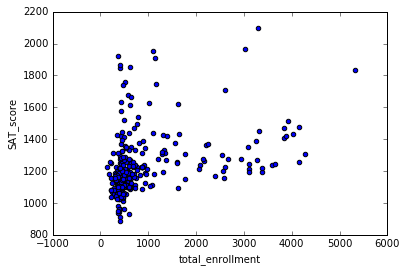

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

full.plot.scatter(x = 'total_enrollment', y = 'SAT_score')

As you can see, there's a cluster at the bottom left with low total enrollment and low SAT scores. Other than this cluster, there appears to only be a slight positive correlation between SAT scores and total enrollment. This is surprising! 
Lets explore this further by getting the names of the schools with low enrollment and low SAT scores:

In [88]:
full[(full['total_enrollment']<1000) & (full['SAT_score']<1000)]['school_name']

21             International School for Liberal Arts
119              International Community High School
144                  Bronx International High School
151            Kingsbridge International High School
183                    High School of World Cultures
191               Brooklyn International High School
212    International High School at Prospect Heights
220                       It Takes a Village Academy
231                        Multicultural High School
256           Pan American International High School
Name: school_name, dtype: object

Most of those schools are International schools (for students who learn english), and that explains the low enrollment rate. This exploration showed us that **it's not** total enrollment that's correlated to SAT score -- it's whether or not students in the school are learning English as a second language or not.

# Exploring English language learners and SAT scores

Now that we know the percentage of English language learners in a school is correlated with lower SAT scores, we can explore the relationship. The ell_percent column is the percentage of students in each school who are learning English. We can make a scatterplot of this relationship:

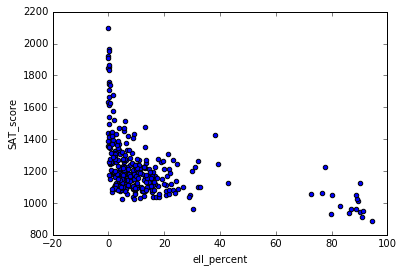

In [91]:
full.plot.scatter(x= 'ell_percent', y='SAT_score')

It looks like there are a group of schools with a high ell_percentage that also have low average SAT scores. We can investigate this at the district level, by figuring out the percentage of English language learners in each district, and seeing it if matches our map of SAT scores by district:

In [93]:
HTML(show_district_map('ell_percent'))

As we can see by looking at the two district level maps, districts with a low proportion of ELL learners tend to have high SAT scores, and vice versa.

# Correlating survey scores and SAT scores
It would be fair to assume that the results of student, parent, and teacher surveys would have a large correlation with SAT scores. It makes sense that schools with high academic expectations, for instance, would tend to have higher SAT scores. To test this theory, lets plot out SAT scores and the various survey metrics:

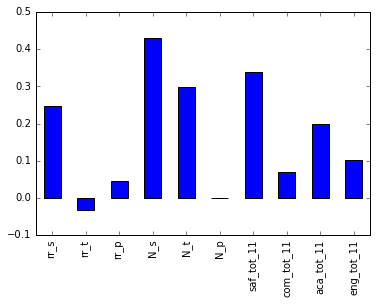

In [141]:
full.corr()["SAT_score"][["rr_s", 
            "rr_t", 
            "rr_p", 
            "N_s", 
            "N_t", 
            "N_p", 
            "saf_tot_11", 
            "com_tot_11",
            "aca_tot_11",
            "eng_tot_11"
           ]].plot.bar()

Surprisingly, the factor that correlate the most is N_s - which is the counts of students who responded to the surveys. N_s strongly correlate with total enrollment, so is likely biased by the ell_learners.
Other factors that correlate with the SAT scores are: 
+ saf_t_11 - That is how safe students, parents, and teachers perceived the school to be. it makes sense that the safer the school, the more comfortable students feel learning in the environment. 
+ N_t - counts of teachers who responded to the surveys.
+ rr_s - Student response rate
+ aca_tot_11 - academic expectations

However, none of the other factors, like engagement, communication, and correlated with SAT scores. This may indicate that NYC is asking the wrong questions in surveys, or thinking about the wrong factors (if their goal is to improve SAT scores, it may not be).

# Exploring race and SAT scores
One of the other angles to investigate involves race and SAT scores. There was a large correlation differential, and plotting it out will help us understand what's happening:

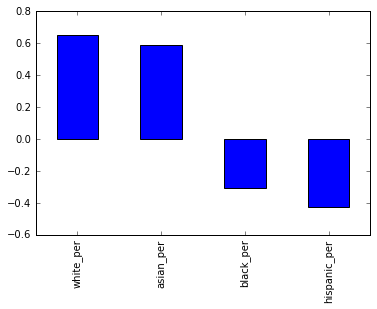

In [144]:
full.corr()['SAT_score'][["white_per", 
                         "asian_per", 
                         "black_per",
                         "hispanic_per"]].plot.bar()

It looks like the higher percentages of white and asian students correlate with higher SAT scores, but higher percentages of black and hispanic students correlate with lower SAT scores. For hispanic students, this may be due to the fact that there are more recent immigrants who are ELL learners. We can map the hispanic percentage by district to eyeball the correlation:

In [145]:
HTML(show_district_map("hispanic_per"))

It looks like there is some correlation with ELL percentage, but it will be necessary to do some more digging into this and other racial differences in SAT scores.

# Gender differences in SAT scores
The final angle to explore is the relationship between gender and SAT score. We noted that a higher percentage of females in a school tends to correlate with higher SAT scores. We can visualize this with a bar graph:

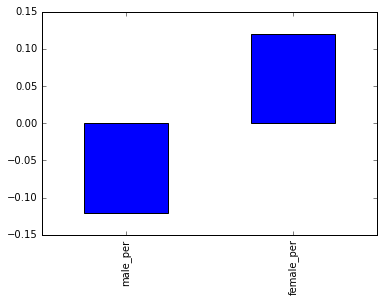

In [147]:
full.corr()["SAT_score"][["male_per", "female_per"]].plot.bar()

To dig more into the correlation, we can make a scatterplot of female_per and sat_score:

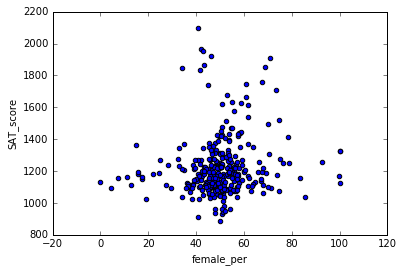

In [149]:
full.plot.scatter(x='female_per', y='SAT_score')

It looks like there's a cluster of schools with a high percentage of females, and very high SAT scores (in the top ). We can get the names of the schools in this cluster:

In [151]:
full[(full["female_per"] > 65) & (full["SAT_score"] > 1400)]["School Name"]

3             PROFESSIONAL PERFORMING ARTS HIGH SCH
58                   BARD HIGH SCHOOL EARLY COLLEGE
74                    ELEANOR ROOSEVELT HIGH SCHOOL
85                     TALENT UNLIMITED HIGH SCHOOL
101            FIORELLO H. LAGUARDIA HIGH SCHOOL OF
268                     TOWNSEND HARRIS HIGH SCHOOL
293    FRANK SINATRA SCHOOL OF THE ARTS HIGH SCHOOL
Name: School Name, dtype: object

Searching Google reveals that these are elite schools that focus on the performing arts. These schools tend to have higher percentages of females, and higher SAT scores. This likely accounts for the correlation between higher female percentages and SAT scores, and the inverse correlation between higher male percentages and lower SAT scores.

# AP scores
So far, we've looked at demographic angles. One angle that we have the data to look at is the relationship between more students taking Advanced Placement exams and higher SAT scores. It makes sense that they would be correlated, since students who are high academic achievers tend to do better on the SAT.

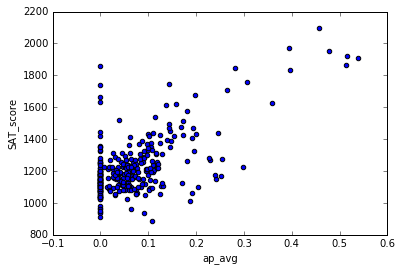

In [152]:
full["ap_avg"] = full["AP Test Takers "] / full["total_enrollment"]

full.plot.scatter(x='ap_avg', y='SAT_score')

It looks like there is indeed a strong correlation between the two. An interesting cluster of schools is the one at the top right, which has high SAT scores and a high proportion of students that take the AP exams:

In [153]:
full[(full["ap_avg"] > .3) & (full["SAT_score"] > 1700)]["School Name"]

74             ELEANOR ROOSEVELT HIGH SCHOOL
82                    STUYVESANT HIGH SCHOOL
161             BRONX HIGH SCHOOL OF SCIENCE
165    HIGH SCHOOL OF AMERICAN STUDIES AT LE
190           BROOKLYN TECHNICAL HIGH SCHOOL
268              TOWNSEND HARRIS HIGH SCHOOL
284    QUEENS HIGH SCHOOL FOR THE SCIENCES A
304      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object

Some Google searching reveals that these are mostly highly selective schools where you need to take a test to get in. It makes sense that these schools would have high proportions of AP test takers.